# Gridworld Experiments

This notebook fully reproduces the gridworld experiments in the paper. Namely it
1. Generates Boltzmann-rational demonstrations on the 3x3 gridworld
2. Runs PolicyWalk on this
3. Runs ValueWalk
4. Runs AVRIL
5. Plots the results
6. Runs PolicyWalk and ValueWalk on a 6x6 and 12x12 gridworld to measure their running times.

In [1]:
import datetime
import importlib
import random
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import torch

from configuration.configurable_factory import resolve_configurable_factories
from envs.gridworld import ObservationType
from experiments.birl.presets.gridworld_presets import get_3x3_irl_gridworld_config
from experiments.birl.presets.priors import get_independent_normal_prior
from irl_algorithms.demonstrations_config import BoltzmannDemosConfig
from irl_algorithms.mcmc_irl import BayesianIRLConfig
from irl_algorithms.policy_walk import PolicyWalk
from irl_algorithms.utils.collect_trajectories import collect_boltzmann_demos_factory_finite
from visualisation.irl import plot_demo_counts

/home/ob/venv/irl-torch/lib/python3.10/site-packages/ray/data/__init__.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources._vendor.packaging.version import parse as parse_version
/home/ob/dev/irl-torch/irl_algorithms/demonstrations_config.py:34: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @pydantic.validator("total_samples")
/home/ob/venv/irl-torch/lib/python3.10/site-packages/pydantic/_internal/_config.py:271: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydant

## 1. Generate demonstrations

In [2]:
from envs.gridworld import GridWorld

grid = [
    [-1, '10T', -1],
    [-1, -10, -1],
    [-1, -1, -1]
]

s0 = np.array([[0,0,0],[0,0,0],[1,0,0]], dtype=np.float32) # Start in the bottom right corner


env = GridWorld(grid,s0_grid=s0, direct_access=True)

map shape: (3, 3), data type: float64


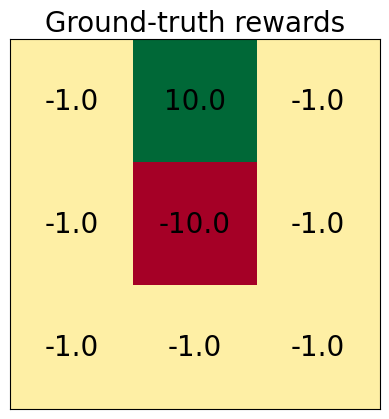

In [3]:
env.visualize_rewards()

In [4]:
from irl_algorithms.utils.collect_trajectories import collect_boltzmann_demos_finite

D = collect_boltzmann_demos_finite(env, 4, 1.)

map shape: (9, 9), data type: float64


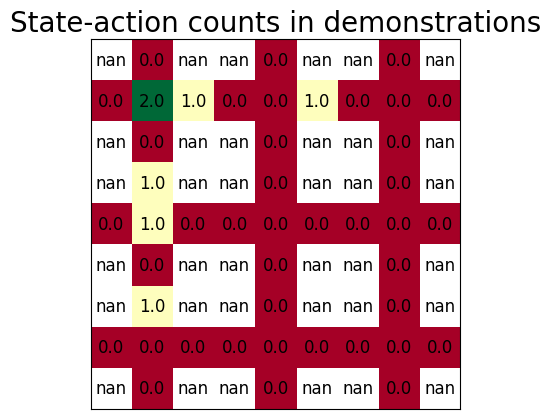

In [5]:
plot_demo_counts(D, env, onehot=False, cell_text_fontsize=12)

In [6]:
seed = 1
beta_expert = 1.

# Set seeds in python, numpy and torch for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

env_config = get_3x3_irl_gridworld_config()
env_config.observation_type = ObservationType.index

demos_config = BoltzmannDemosConfig(
        demo_factory=collect_boltzmann_demos_factory_finite,
        total_samples=50,
        beta_expert=beta_expert,
        append_last=False
    )

In [7]:
resolve_configurable_factories(env_config)
env = env_config.env_factory()

map shape: (3, 3), data type: float64


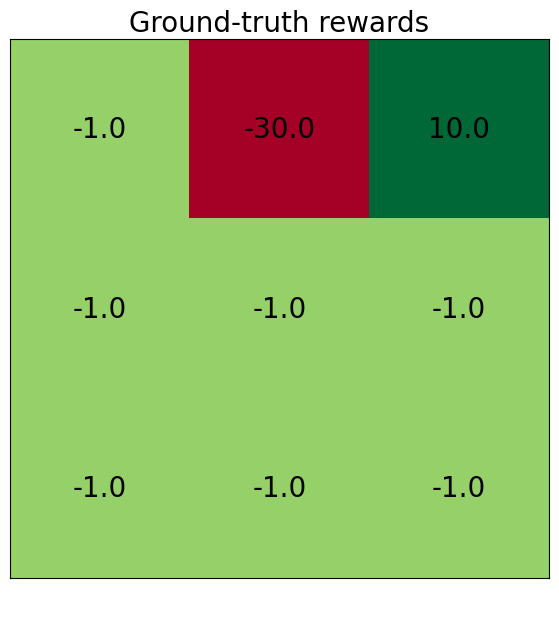

In [8]:
env.visualize_rewards(figsize=(7,7))
plt.xlabel(" ", fontsize=18)
plt.savefig("3x3_obstacle_gridworld.pdf",bbox_inches='tight')
plt.show()

map shape: (9, 9), data type: float64


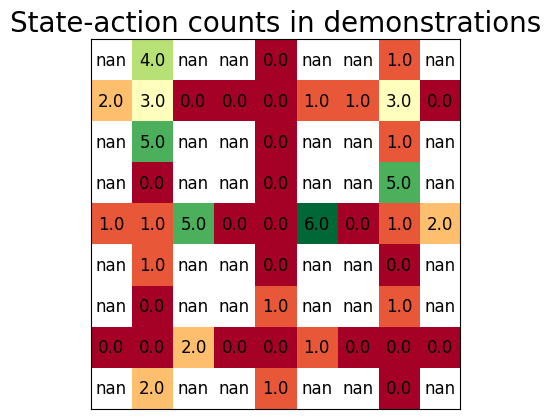

In [9]:
resolve_configurable_factories(demos_config)
D = demos_config.demo_factory(env)
plot_demo_counts(D, env, onehot=False, cell_text_fontsize=12)
plt.savefig("3x3_obstacle_gridworld_demos.pdf",bbox_inches='tight')

## 2. Run PolicyWalk

In [10]:
irl_config = BayesianIRLConfig(
        irl_method_factory=PolicyWalk,
        beta_expert=1.,
    
        reward_prior_factory=get_independent_normal_prior,
        prior_scale=10.,
        reward_eval_points=3 * 3, # Determines the dimensionality of the prior
    
        # HMC configuration
        num_samples=1000,
        warmup_steps=100,
    
        hmc_adapt_mass_matrix=False,
        hmc_adapt_step_size=True,
        hmc_step_size=.1,
        hmc_use_nuts=True,
        pyro_jit_compile=False # JIT does not work for PolicyWalk (runs but gives wrong results)
)

In [11]:
resolve_configurable_factories(irl_config)

In [12]:
policy_walk = irl_config.irl_method_factory(env, irl_config)

In [13]:
start_time = datetime.datetime.now()

policywalk_reward_model, info = policy_walk.run(D)

policywalk_runtime = datetime.datetime.now() - start_time
print(f"PolicyWalk runtime: {policywalk_runtime} s")

Sample: 100%|██████████| 1100/1100 [02:02,  8.95it/s, step size=8.35e-02, acc. prob=0.857]

PolicyWalk runtime: 0:02:02.941185 s


In [14]:
# Save results
policywalk_samples = policywalk_reward_model.param_samples
# torch.save(policywalk_reward_model.param_samples, "vw_reward_samples.pt")
# policywalk_samples = torch.load("vw_reward_samples.pt")

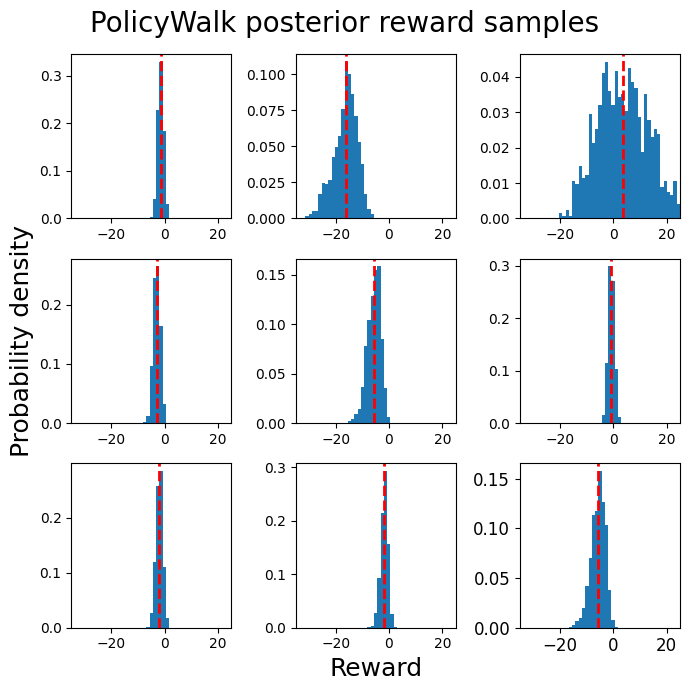

In [15]:
x_lims = (-35, 25)
n_bins = 50
bins = np.linspace(x_lims[0], x_lims[1], n_bins)
def plot_hist_grid(samples, title="ValueWalk posterior reward samples"):
    
    # Plot with a tight layout
    
    plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        # if i ==1:
        #     plt.hist(samples[:,i].numpy(), bins=50, density=True)
        # 
        #     plt.xlim((-30,10))
        # else:
        plt.hist(samples[:,i].numpy(), bins=bins, density=True)
        # Add a vertical line representing the mean
        plt.axvline(samples[:,i].mean(), color='r', linestyle='dashed', linewidth=2)
        plt.xlim(x_lims)
        # plt.ylim(0, 0.1)
        if i == 7:
            plt.xlabel('Reward', fontsize=18)
        if i == 3:
            plt.ylabel('Probability density', fontsize=18)
    plt.tick_params(labelsize=12)
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    
plot_hist_grid(policywalk_reward_model.param_samples, title="PolicyWalk posterior reward samples")

## Single-param learning

In [16]:
from irl_algorithms.irl_method import IRLMethod
from envs.gridworld import FiniteMDP
from irl_algorithms.demonstrations import Demonstrations
from rl_algorithms.tabular.value_iteration import ValueIteration
import pyro
from models.reward_models.linear_reward_model import MonteCarloLinearRewardModel
from typing import Any

PW_REWARD_KEY = 'r_s'

mud_squares = [4]

fixed_rewards = -1 * torch.ones(10, dtype=torch.float)
fixed_rewards[1] = 10
fixed_rewards[-1] = 0
fixed_rewards[mud_squares] = 0

mud_mask = torch.zeros(10, dtype=torch.float)
mud_mask[mud_squares] = 1


def policy_walk_model(s_t, a_t, reward_prior, P_sas, value_iteration_instance=None, beta_expert=4, beta_opt=10,
                      gamma=0.9, zero_final_reward=True):
    """

    :param s_t:
    :param a_t:
    :param reward_prior:
    :param P_sas:
    :param value_iteration_instance: value iteration instance that can cache the previous value
    :param beta_expert: softmax coefficient for expert policy
    :param beta_opt: softmax coefficient for optimal policy in soft value iteration
    :param gamma: discount factor
    :param zero_final_reward: should be True if we enforce a 0 reward on the terminal state
    :return:
    """

    if value_iteration_instance is None:
        value_iteration = ValueIteration()
    else:
        value_iteration = value_iteration_instance

    # Sample reward values
    mud_param = pyro.sample(PW_REWARD_KEY, reward_prior)

    r_s = fixed_rewards + mud_mask * mud_param

    # Calculate corresponding Q values using the transition model
    q_sa = value_iteration.run(P_sas=P_sas, r=r_s, gamma=gamma)

    # Forces the Q value to be recorded by Pyro
    q_sa = pyro.deterministic('q_sa', q_sa)

    likelihood = pyro.distributions.Categorical(logits=beta_expert*q_sa[s_t, :])

    with pyro.plate('data', len(s_t)):
        return pyro.sample('obs', likelihood, obs=a_t)


class PolicyWalk(IRLMethod):

    def __init__(self, env: FiniteMDP, config: BayesianIRLConfig):
        assert env.direct_access, f"{self.__class__.__name__} requires direct access to the transition dynamics"
        super().__init__(env, config)

        self.reward_prior = config.reward_prior_factory()

    def run(self, demonstrations_t: Demonstrations) -> (MonteCarloLinearRewardModel, Dict[str, Any]):
        nuts_kernel = pyro.infer.NUTS(policy_walk_model)
        value_iteration = ValueIteration()

        mcmc = pyro.infer.MCMC(nuts_kernel,
                               num_samples=self.config.num_samples,
                               warmup_steps=self.config.warmup_steps,
                               num_chains=self.config.num_chains,
                               disable_validation=False)

        mcmc.run(s_t=demonstrations_t.states_tensor.long(),
                 a_t=demonstrations_t.actions_tensor.squeeze(-1),
                 reward_prior=self.reward_prior,
                 P_sas=torch.tensor(self.env.P_sas, dtype=torch.float),
                 beta_expert=self.config.beta_expert,
                 value_iteration_instance=value_iteration)

        samples = mcmc.get_samples(group_by_chain=False)
        predictive = pyro.infer.Predictive(policy_walk_model, samples, return_sites=['q_sa'])
        q_samples = predictive(s_t=demonstrations_t.states_tensor.long(),
                 a_t=demonstrations_t.actions_tensor.squeeze(-1),
                 reward_prior=self.reward_prior,
                 P_sas=torch.tensor(self.env.P_sas, dtype=torch.float),
                 beta_expert=self.config.beta_expert,
                 value_iteration_instance=value_iteration)


        return MonteCarloLinearRewardModel(param_samples=samples[PW_REWARD_KEY],
                                           aux_samples=q_samples), {}

In [17]:
from irl_algorithms.demonstrations import Trajectory, Demonstrations

In [18]:
irl_config = BayesianIRLConfig(
    irl_method_factory=PolicyWalk,
    # possible_mud_aversion=possible_mud_aversion,
    beta_expert=1.,
    reward_prior_factory=get_independent_normal_prior, # Irrelevant
    num_samples=10000, #was 1000
    warmup_steps=100, #was 100
    num_params=1,
    prior_scale=5.,  # exp(3)
    reward_eval_points=1,
    gamma=0.8,

    hmc_adapt_mass_matrix=False, # Irrelevant
)

In [19]:
resolve_configurable_factories(irl_config)
pw = irl_config.irl_method_factory(env, irl_config)

In [20]:
start_time = datetime.datetime.now()

pw_reward_model, info = pw.run(D)

pw_runtime = datetime.datetime.now() - start_time
print(f"PolicyWalk runtime: {pw_runtime} s")

Sample: 100%|██████████| 10100/10100 [01:57, 86.31it/s, step size=5.19e-01, acc. prob=0.903] 


PolicyWalk runtime: 0:02:04.871252 s


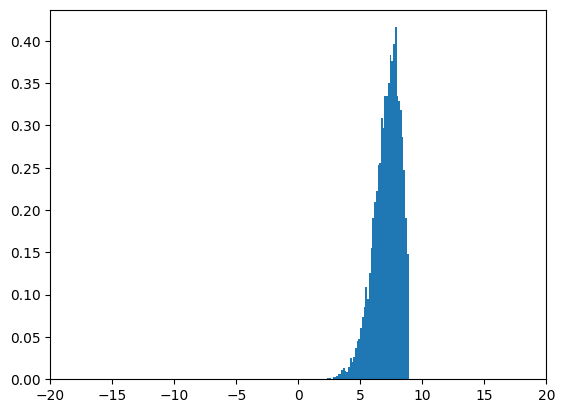

In [27]:
plt.hist(pw_reward_model.param_samples[:,0], bins=50, density=True)
plt.xlim((-20,20))
plt.savefig("pw_poster_reward_samples.eps", bbox_inches='tight')

In [22]:
torch.mean(pw_reward_model.param_samples)

tensor(7.1299)

In [23]:
value_iteration = ValueIteration()
r = fixed_rewards + mud_mask * pw_reward_model.param_samples.mean()
q_sa = value_iteration.run(P_sas=torch.tensor(env.P_sas, dtype=torch.float), r=r.squeeze(), gamma=0.8)

map shape: (9, 9), data type: float64


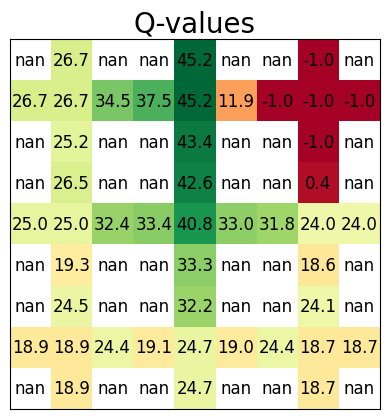

In [24]:
env.q_heatmap(q_sa.detach().numpy(), cell_text_fontsize=12)

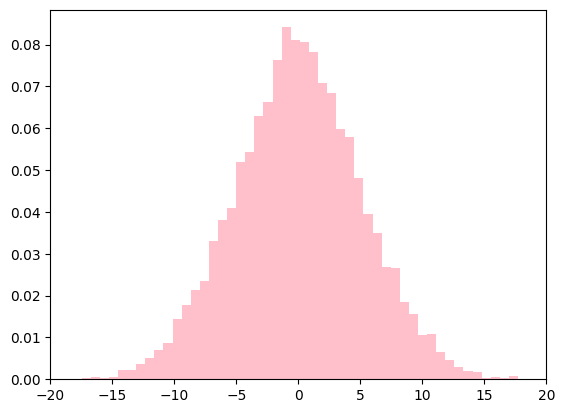

In [26]:
# Sample 10k samples from the prior and make a histogram
prior_samples = pw.reward_prior.sample((10000,))
plt.hist(prior_samples[:,0], bins=50, density=True, color="pink")
plt.xlim((-20,20))
plt.savefig("pw_poster_prior_samples.eps", bbox_inches='tight')

## 3. Run ValueWalk

In [11]:
from irl_algorithms.value_walk import value_walk_tabular

irl_config = BayesianIRLConfig(
        irl_method_factory=value_walk_tabular.ValueWalkTabular,
        beta_expert=1.,
        reward_prior_factory=get_independent_normal_prior,
        num_samples=1000,
        warmup_steps=100,
        num_params=env_config.num_states - 1,
        prior_scale=10.,
        reward_eval_points=env_config.width * env_config.height,
        hmc_adapt_mass_matrix=False,
        hmc_adapt_step_size=True,
        hmc_step_size=0.1,
        hmc_use_nuts=True,
        pyro_jit_compile=False  # Disabled to match the PolicyWalk implementation, but can be enabled for a speedup
)
resolve_configurable_factories(irl_config)

In [12]:
value_walk = irl_config.irl_method_factory(env, irl_config)

In [13]:
start_time = datetime.datetime.now()

value_walk_reward_model, info = value_walk.run(D)

value_walk_runtime = datetime.datetime.now() - start_time
print(f"ValueWalk runtime: {value_walk_runtime} s")

Sample: 100%|██████████| 1100/1100 [00:39, 27.57it/s, step size=4.66e-01, acc. prob=0.903]

ValueWalk runtime: 0:00:39.894834 s


In [14]:
P_sas = torch.tensor(env.P_sas[:-1, :, :-1], dtype=torch.float)

def v_s_to_r_s(v_s, gamma=0.9):
    next_Q_sa = P_sas @ v_s
    
    r_s = v_s - gamma * torch.max(next_Q_sa, dim=1).values
    
    return r_s

vw_rewards = torch.stack([v_s_to_r_s(v_s) for v_s in value_walk_reward_model.param_samples])

In [15]:
value_walk_reward_model.param_samples.shape

torch.Size([1000, 9])

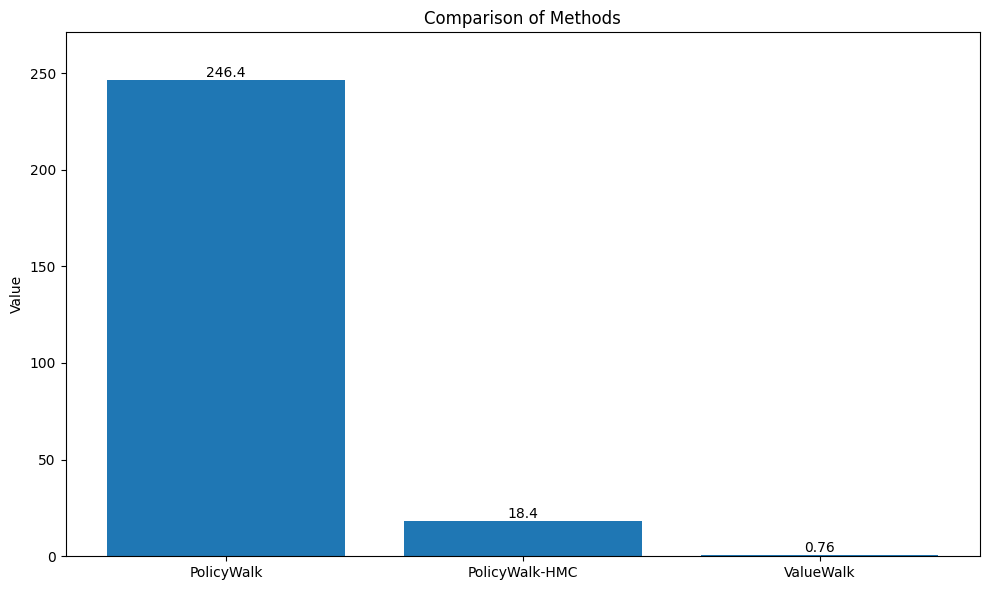

In [28]:
import matplotlib.pyplot as plt

# Data
methods = ['PolicyWalk', 'PolicyWalk-HMC', 'ValueWalk']
values = [246.4, 18.4, 0.76]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

# Customize the plot
plt.title('Comparison of Methods')
plt.ylabel('Value')
plt.ylim(0, max(values) * 1.1)  # Set y-axis limit to 110% of max value

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

## 4. Run AVRIL

In [16]:
from irl_algorithms import avril

importlib.reload(avril)

irl_config = BayesianIRLConfig(
    irl_method_factory=avril.AVRIL,
    beta_expert=1.,
    reward_prior_factory=get_independent_normal_prior,
    num_params=env_config.num_states - 1,
    prior_scale=10.,
    reward_eval_points=env_config.width * env_config.height,
    constraint_weight=1.,

    epochs=50000,
    svi_reporting_frequency=100,
    svi_lr=0.001,

    q_model_inputs=9,
    q_model_hidden_layer_sizes=None,
    state_only=True,
    last_state_q_penalty=10.,

    gamma=0.9,
)

resolve_configurable_factories(irl_config)


In [17]:
env_config.observation_type = ObservationType.onehot
env = env_config.env_factory()
avril_instance = irl_config.irl_method_factory(env, irl_config)

In [18]:
from irl_algorithms.demonstrations import Trajectory, Demonstrations

start_time = datetime.datetime.now()

D_onehot = Demonstrations(trajectories=[Trajectory(oa_pairs=[(torch.nn.functional.one_hot(s, num_classes=10).float(), a) for s, a in traj], truncated=traj.truncated, terminated=traj.terminated) for traj in D])
avril_reward_model, info = avril_instance.run(D_onehot)

avril_runtime = datetime.datetime.now() - start_time

Mean Reward: -1938.24, Eval Time: 0:00:01.778275
Epoch: 100, Iter: 100, Train loss: 4.7357, Test Reward: -1938.2400, Epoch time: 0:00:00.000647
Mean Reward: -1186.12, Eval Time: 0:00:00.408119
Epoch: 200, Iter: 200, Train loss: 4.2734, Test Reward: -1186.1200, Epoch time: 0:00:00.000674
Mean Reward: -68.89, Eval Time: 0:00:00.207313
Epoch: 300, Iter: 300, Train loss: 4.1983, Test Reward: -68.8900, Epoch time: 0:00:00.000671
Mean Reward: -63.54, Eval Time: 0:00:00.178329
Epoch: 400, Iter: 400, Train loss: 4.1385, Test Reward: -63.5400, Epoch time: 0:00:00.000650
Mean Reward: -32.49, Eval Time: 0:00:00.091117
Epoch: 500, Iter: 500, Train loss: 4.0833, Test Reward: -32.4900, Epoch time: 0:00:00.000657
Mean Reward: -32.36, Eval Time: 0:00:00.084354
Epoch: 600, Iter: 600, Train loss: 4.0390, Test Reward: -32.3600, Epoch time: 0:00:00.000649
Mean Reward: -36.07, Eval Time: 0:00:00.099867
Epoch: 700, Iter: 700, Train loss: 3.9980, Test Reward: -36.0700, Epoch time: 0:00:00.000646
Mean Reward:

## 5. Plot the results

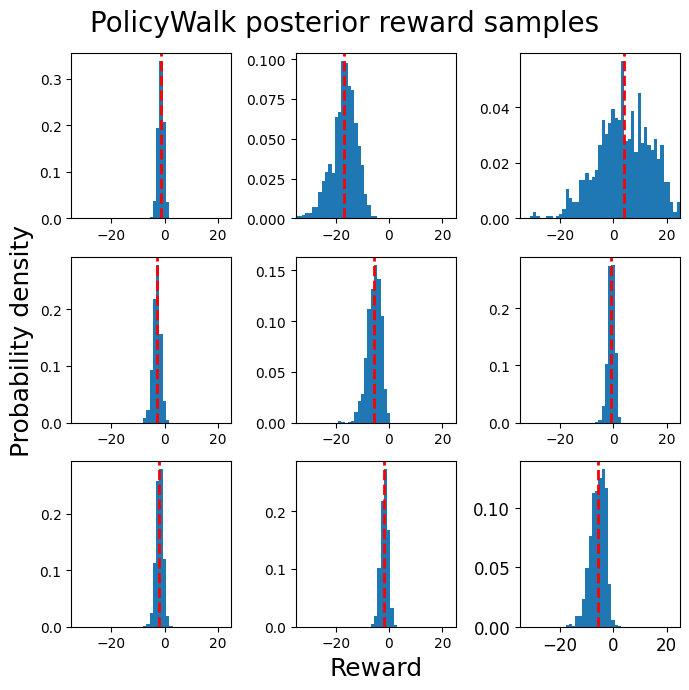

In [19]:
x_lims = (-35, 25)
n_bins = 50
bins = np.linspace(x_lims[0], x_lims[1], n_bins)
def plot_hist_grid(samples, title="ValueWalk posterior reward samples"):
    
    # Plot with a tight layout
    
    plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        # if i ==1:
        #     plt.hist(samples[:,i].numpy(), bins=50, density=True)
        # 
        #     plt.xlim((-30,10))
        # else:
        plt.hist(samples[:,i].numpy(), bins=bins, density=True)
        # Add a vertical line representing the mean
        plt.axvline(samples[:,i].mean(), color='r', linestyle='dashed', linewidth=2)
        plt.xlim(x_lims)
        # plt.ylim(0, 0.1)
        if i == 7:
            plt.xlabel('Reward', fontsize=18)
        if i == 3:
            plt.ylabel('Probability density', fontsize=18)
    plt.tick_params(labelsize=12)
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    
plot_hist_grid(policywalk_reward_model.param_samples, title="PolicyWalk posterior reward samples")

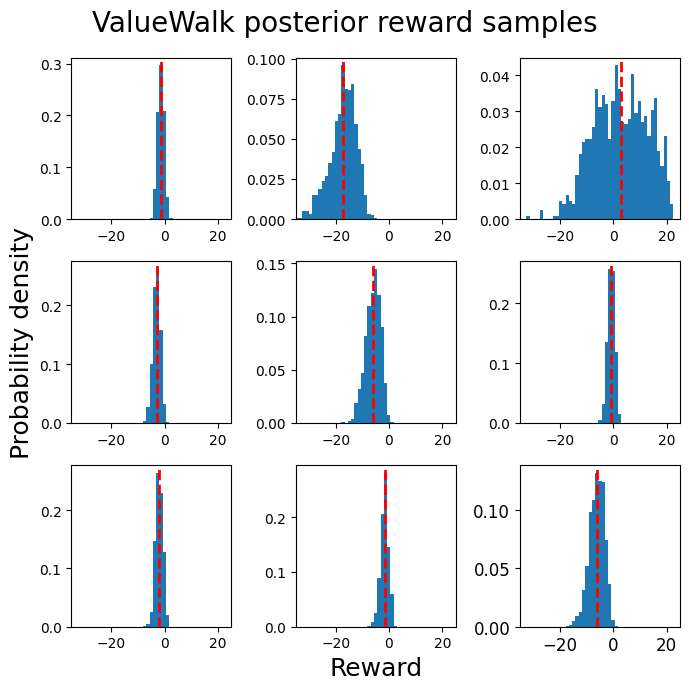

In [20]:
plot_hist_grid(vw_rewards, title="ValueWalk posterior reward samples")
plt.savefig("vw_gridworld_reward_samples.pdf", bbox_inches='tight')

In [21]:
x_lims = (-35, 25)
n_bins = 50
bins = np.linspace(x_lims[0], x_lims[1], n_bins)

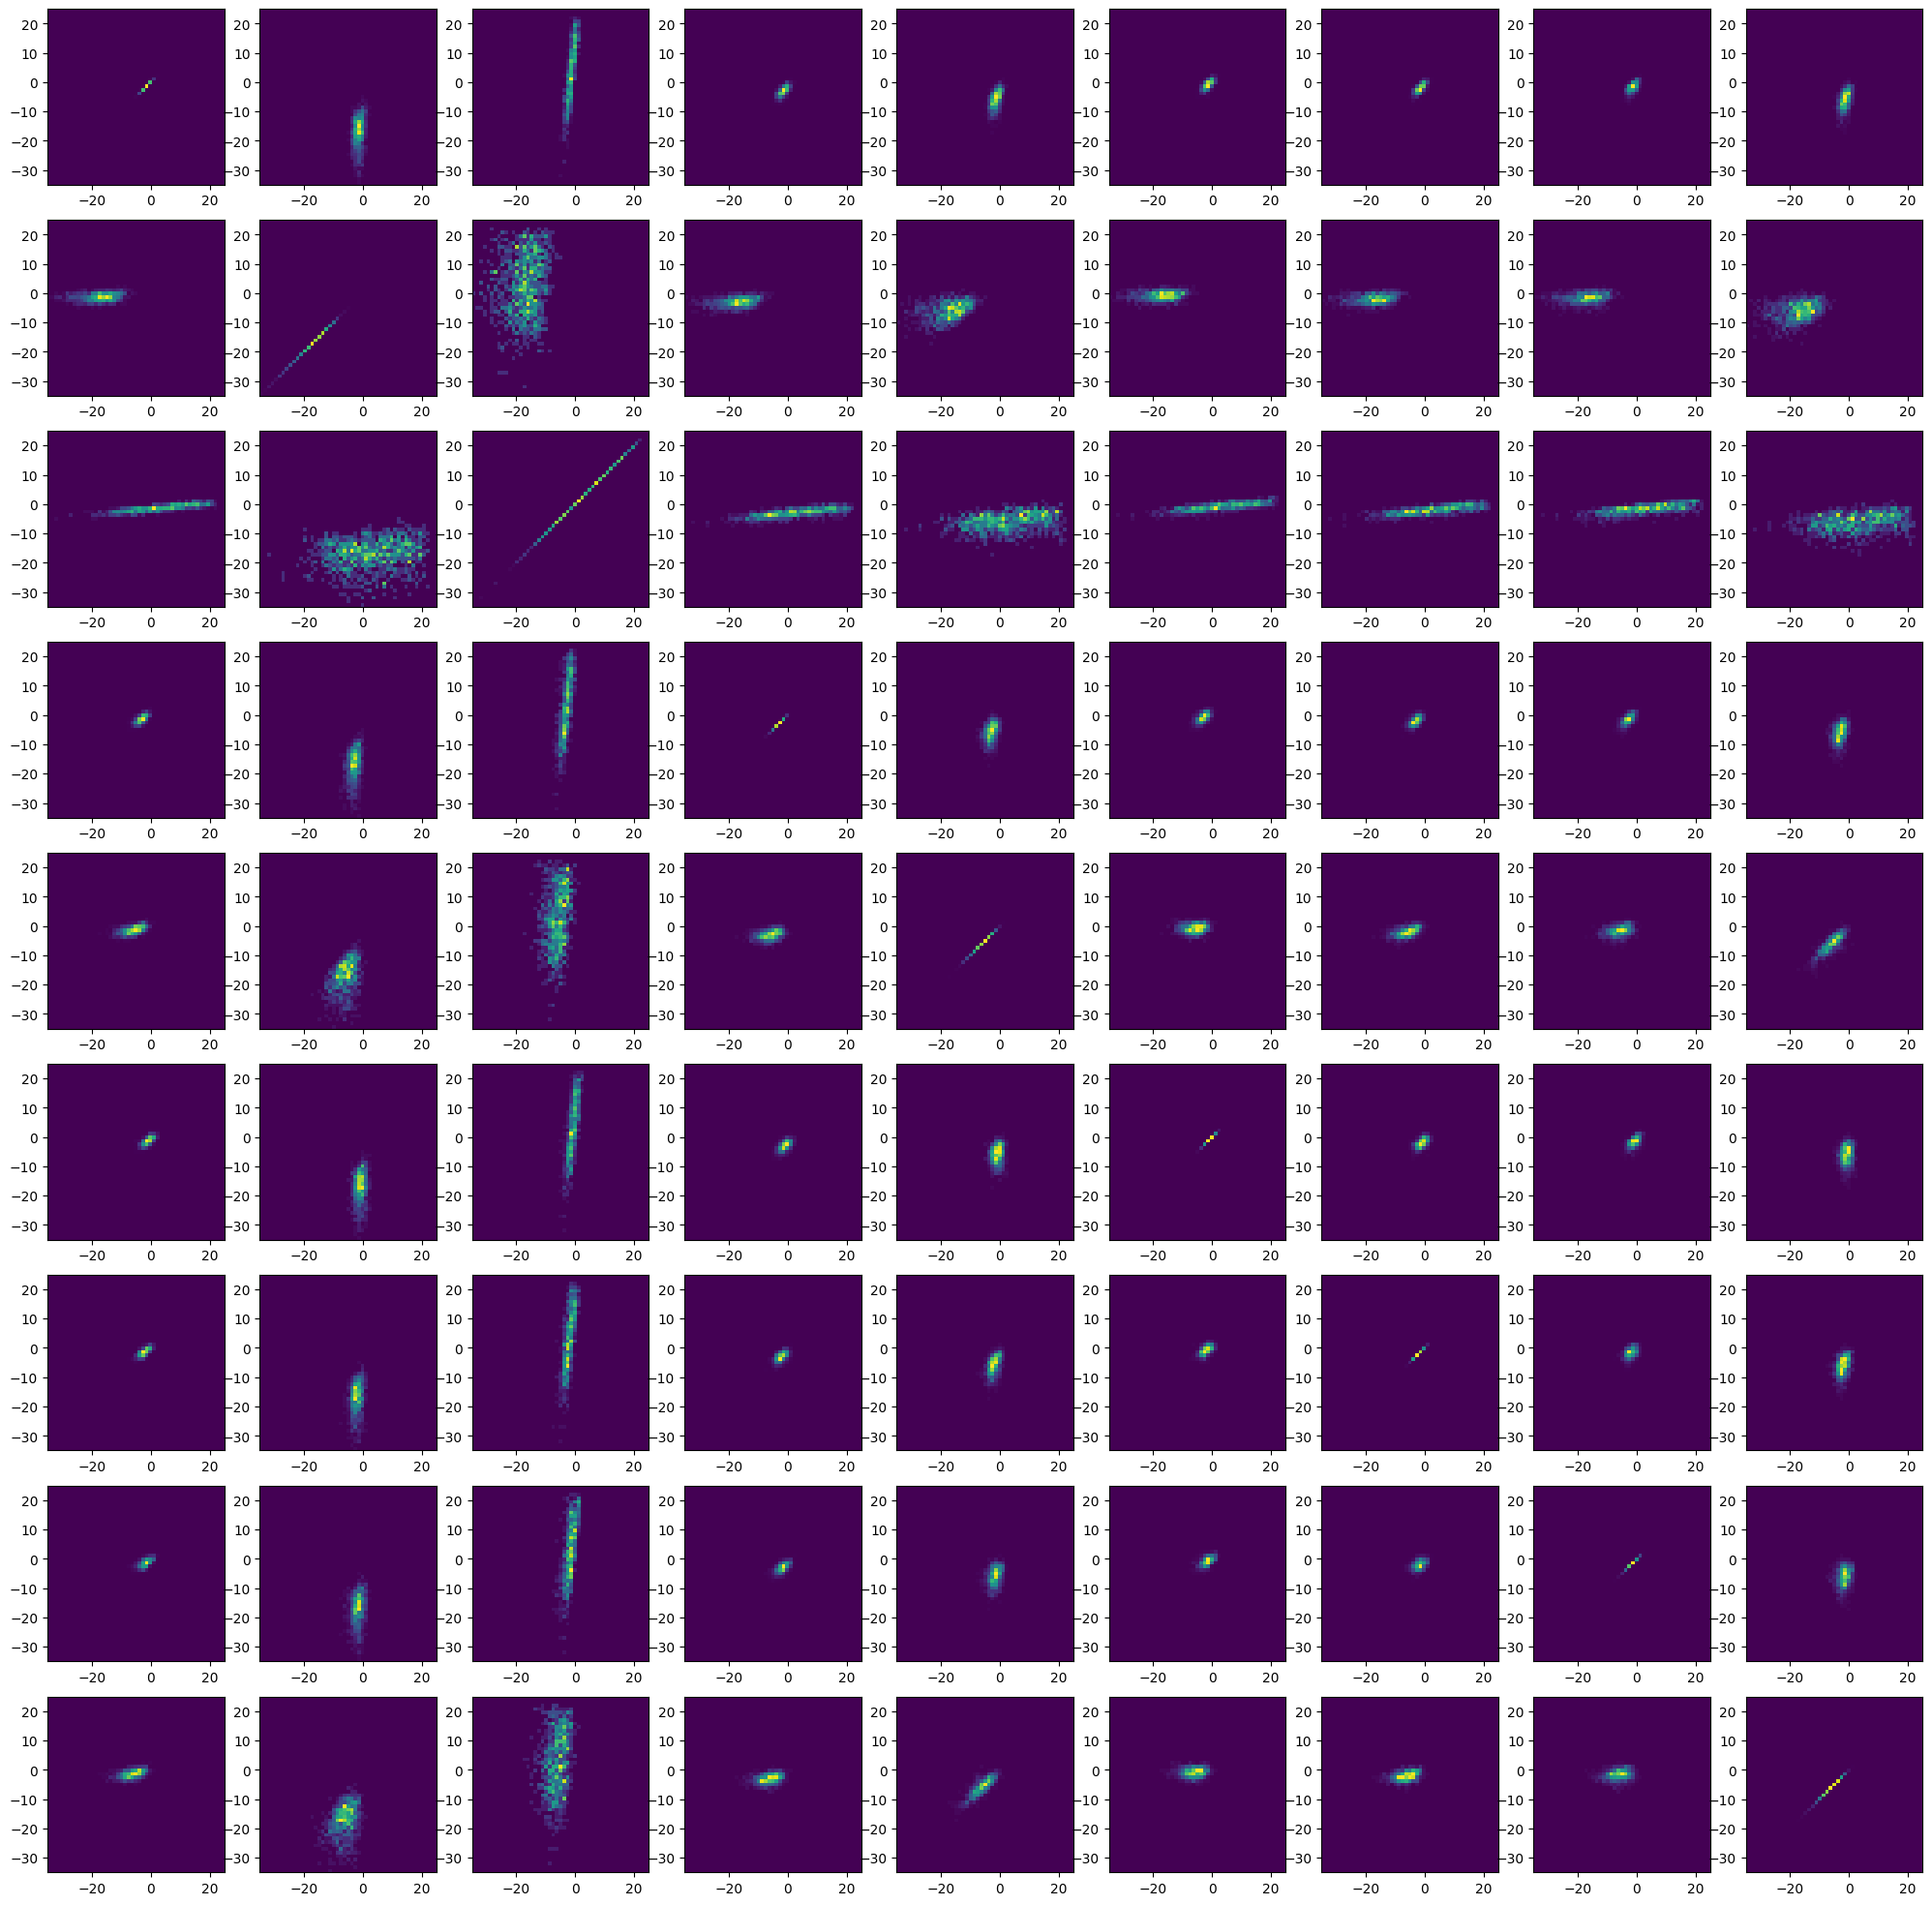

In [22]:

plt.figure(figsize=(25,25))
# plt.suptitle('Pairwise joint distributions of the 9 states in a 9x9 grid')
for i in range(9):
    for j in range(9):
        plt.subplot(9,9,9*i+j+1)
        plt.hist2d(vw_rewards[:,i].numpy(), vw_rewards[:,j].numpy(), bins=bins)
        plt.xlim(x_lims)
plt.savefig('pairwise_joint_distributions.pdf')

In [23]:
# Run multivariate Kolmogorov Smirnov test on the two reward samples
from scipy.stats import ks_2samp
for i in range(9):
    # Note that the test can be sensitive to repeated values, which occur in MCMC sampling. We therefore thin the samples by taking every 5th sample (still leaving 200 samples per dimension)
    print(ks_2samp(policywalk_reward_model.param_samples[::5,i].numpy(), vw_rewards[::5,i].numpy()))

KstestResult(statistic=0.065, pvalue=0.7933622419382523, statistic_location=-0.1494213, statistic_sign=1)
KstestResult(statistic=0.08, pvalue=0.5452713464323318, statistic_location=-19.399662, statistic_sign=-1)
KstestResult(statistic=0.1, pvalue=0.2704743832803917, statistic_location=-2.6231089, statistic_sign=-1)
KstestResult(statistic=0.045, pvalue=0.9877895282790693, statistic_location=-2.1822605, statistic_sign=-1)
KstestResult(statistic=0.105, pvalue=0.220541217580421, statistic_location=-8.029065, statistic_sign=-1)
KstestResult(statistic=0.06, pvalue=0.8655265369450457, statistic_location=-0.3026444, statistic_sign=1)
KstestResult(statistic=0.115, pvalue=0.1420746514551761, statistic_location=-1.5939732, statistic_sign=-1)
KstestResult(statistic=0.1, pvalue=0.2704743832803917, statistic_location=-2.4175448, statistic_sign=1)
KstestResult(statistic=0.12, pvalue=0.11228360286766195, statistic_location=-4.563282, statistic_sign=-1)


Thus, the samples are consistent with being drawn from the same distribution.

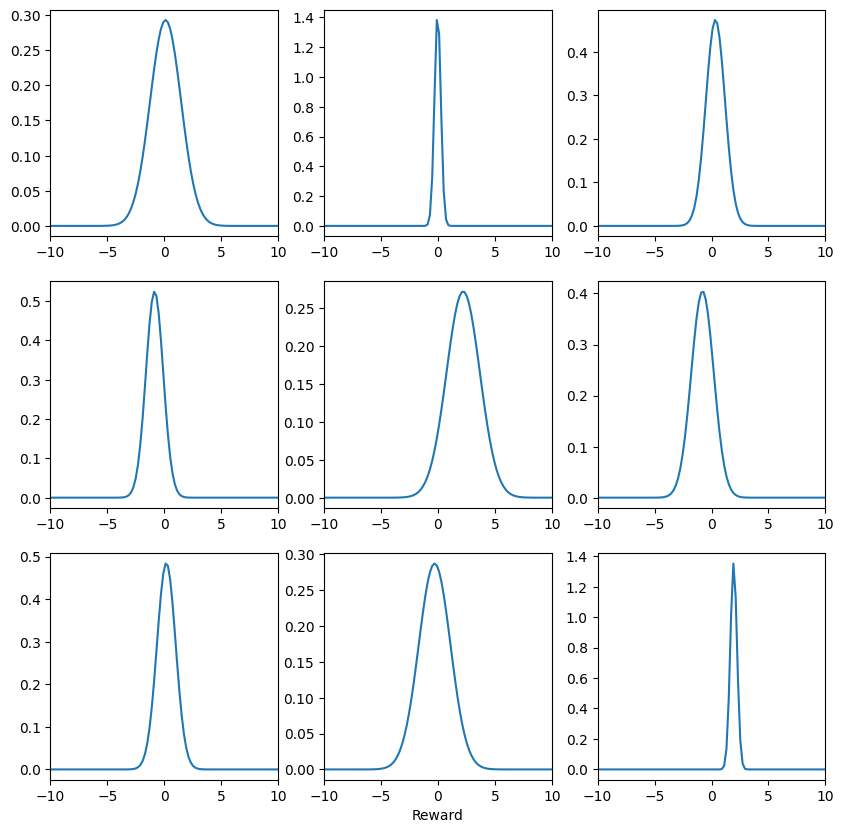

In [24]:
def plot_variational_reward_pdfs(model, x_lims=(-100, 100)):
    plt.figure(figsize=(10, 10))
    rew_model = model.reward_model
    r_plot = torch.linspace(*x_lims, 100)
    for i in range(9):
        s = torch.nn.functional.one_hot(torch.tensor(i), num_classes=10, ).float()
        plt.subplot(3, 3, i + 1)
        m, log_var = rew_model(s)
        dist = torch.distributions.Normal(m, log_var.exp().sqrt())
        plt.plot(r_plot, dist.log_prob(r_plot).exp().detach().numpy())
        plt.xlim(x_lims)
        # plt.ylim(0, 0.8)
        if i == 7:
            plt.xlabel('Reward')


plot_variational_reward_pdfs(avril_reward_model, (-10, 10))

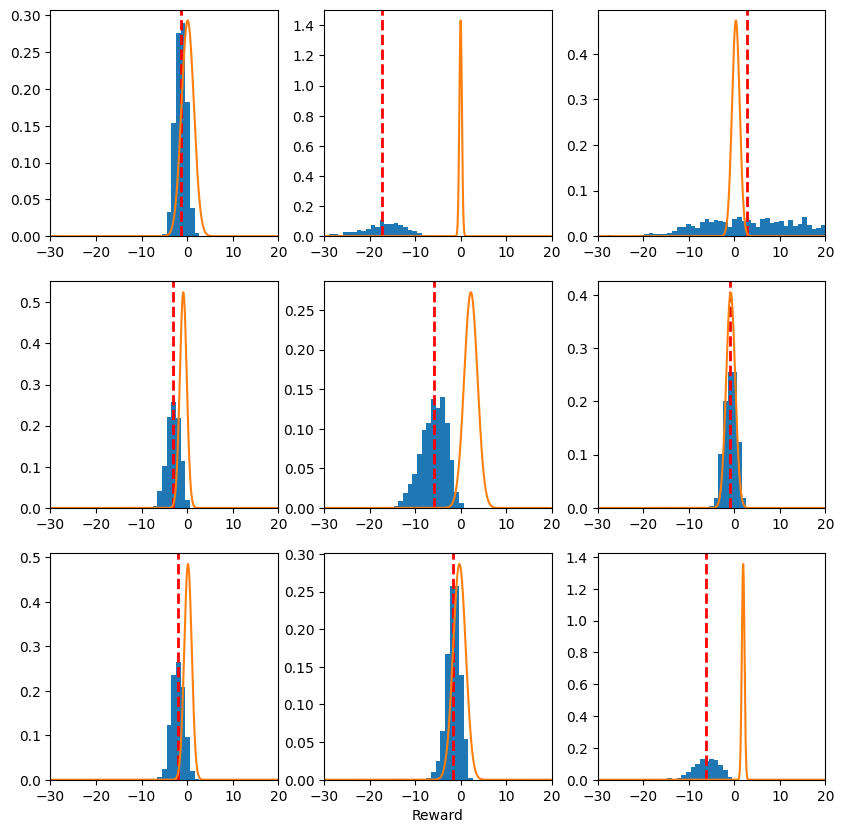

In [25]:
x_lims = (-30, 20)
n_bins = 50
bins = np.linspace(x_lims[0], x_lims[1], n_bins)

plt.figure(figsize=(10, 10))
rew_model = avril_reward_model.reward_model
r_plot = torch.linspace(*x_lims, 1000)
for i in range(9):
    plt.subplot(3, 3, i + 1)

    plt.hist(vw_rewards[:,i].numpy(), bins=bins, density=True)
    # Add a vertical line representing the mean
    plt.axvline(vw_rewards[:,i].mean(), color='r', linestyle='dashed', linewidth=2)
    
    
    s = torch.nn.functional.one_hot(torch.tensor(i), num_classes=10, ).float()
    m, log_var = rew_model(s)
    dist = torch.distributions.Normal(m, log_var.exp().sqrt())
    plt.plot(r_plot, dist.log_prob(r_plot).exp().detach().numpy())
    plt.xlim(x_lims)
    # plt.ylim(0, 0.8)
    if i == 7:
        plt.xlabel('Reward')


## AVRIL with TD and KL evaluation everywhere

In [27]:
from torch.distributions import Normal

P_sas = torch.tensor(env.P_sas, dtype=torch.float)


class MBAVRIL(avril.AVRIL):
    def kl(self, n_states=10):
        all_states = torch.eye(n_states)
        r_params = self.encoder(all_states)
        means = r_params[:, 0]
        log_sds = r_params[:, 1]
        kl = (self.prior_log_scale - log_sds +
                0.5 * (log_sds.exp() ** 2 + means ** 2)/self.config.prior_scale**2).mean()
        return kl

    def td_loss(self, P_sas: torch.Tensor = P_sas, n_states=10):
        all_states = torch.eye(n_states)
        r_params = self.encoder(all_states)
        means = r_params[:, 0]
        log_sds = r_params[:, 1]
        sds = torch.exp(log_sds)

        q_vals_sa = self.q_network(all_states)
        v_s = torch.max(q_vals_sa, dim=1)[0]
        vals_next_sa = P_sas @ v_s
        td = q_vals_sa - self.config.gamma * vals_next_sa
        td_loss = -Normal(means, sds).log_prob(td.T).mean()
        return td_loss
    
    def elbo(self, states_b2f: torch.Tensor, actions_b2_: torch.Tensor) -> torch.Tensor:
        q_values_ba, q_values_realized_b, q_values_next_realized_b, means_b, log_sds_b = self.q_vals_and_r_params(states_b2f, actions_b2_)

        action_logits_ba = torch.nn.functional.log_softmax(self.config.beta_expert * q_values_ba, dim=1)
        neg_log_lik = -action_logits_ba.gather(1, actions_b2_[:, :1]).mean()
                
        # The following is a hack to keep the last state Q vals at 0 (to handle the terminal state)
        last_state = torch.nn.functional.one_hot(torch.tensor(states_b2f.shape[-1]-1),
                                                 num_classes=states_b2f.shape[-1]).float()
        last_state_penalty = self.config.last_state_q_penalty * (self.q_network(last_state)**2).mean()


        return neg_log_lik + self.kl() + self.config.constraint_weight * self.td_loss() + last_state_penalty

In [28]:
irl_config = BayesianIRLConfig(
    irl_method_factory=MBAVRIL,
    beta_expert=1.,
    reward_prior_factory=get_independent_normal_prior,
    num_params=env_config.num_states - 1,
    prior_scale=10.,
    reward_eval_points=env_config.width * env_config.height,
    constraint_weight=1.,

    epochs=20000,
    svi_reporting_frequency=100,
    svi_lr=0.001,

    q_model_inputs=9,
    q_model_hidden_layer_sizes=None,
    state_only=True,
    last_state_q_penalty=10.,

    gamma=0.9,
)
resolve_configurable_factories(irl_config)

In [29]:
mbavril = irl_config.irl_method_factory(env, irl_config)


In [30]:
start_time = datetime.datetime.now()

mbavril_reward_model, info = mbavril.run(D_onehot)

mbavril_runtime = datetime.datetime.now() - start_time


Mean Reward: -74.24, Eval Time: 0:00:00.244837
Epoch: 100, Iter: 100, Train loss: 4.9674, Test Reward: -74.2400, Epoch time: 0:00:00.000766
Mean Reward: -59.89, Eval Time: 0:00:00.202599
Epoch: 200, Iter: 200, Train loss: 4.7437, Test Reward: -59.8900, Epoch time: 0:00:00.000762
Mean Reward: -62.18, Eval Time: 0:00:00.196218
Epoch: 300, Iter: 300, Train loss: 4.6513, Test Reward: -62.1800, Epoch time: 0:00:00.000789
Mean Reward: -64.12, Eval Time: 0:00:00.187072
Epoch: 400, Iter: 400, Train loss: 4.5919, Test Reward: -64.1200, Epoch time: 0:00:00.000770
Mean Reward: -34.39, Eval Time: 0:00:00.085162
Epoch: 500, Iter: 500, Train loss: 4.5435, Test Reward: -34.3900, Epoch time: 0:00:00.000904
Mean Reward: -33.98, Eval Time: 0:00:00.087026
Epoch: 600, Iter: 600, Train loss: 4.5016, Test Reward: -33.9800, Epoch time: 0:00:00.000950
Mean Reward: -35.37, Eval Time: 0:00:00.094445
Epoch: 700, Iter: 700, Train loss: 4.4669, Test Reward: -35.3700, Epoch time: 0:00:00.000891
Mean Reward: -32.22,

In [31]:
mbavril_runtime

datetime.timedelta(seconds=23, microseconds=118487)

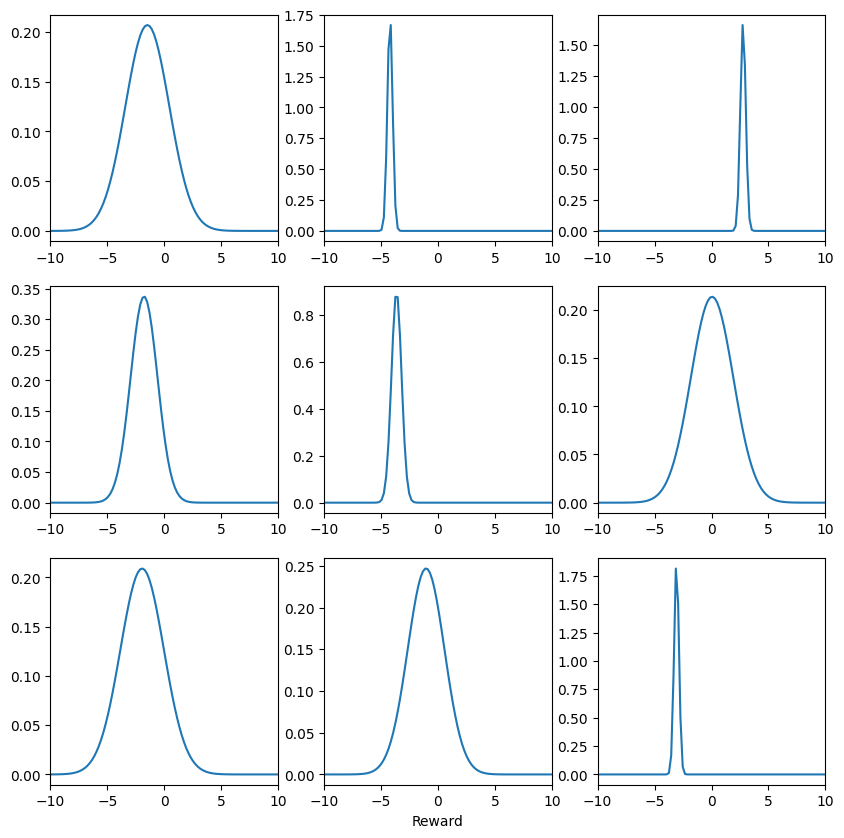

In [32]:
plot_variational_reward_pdfs(mbavril_reward_model, (-10, 10))

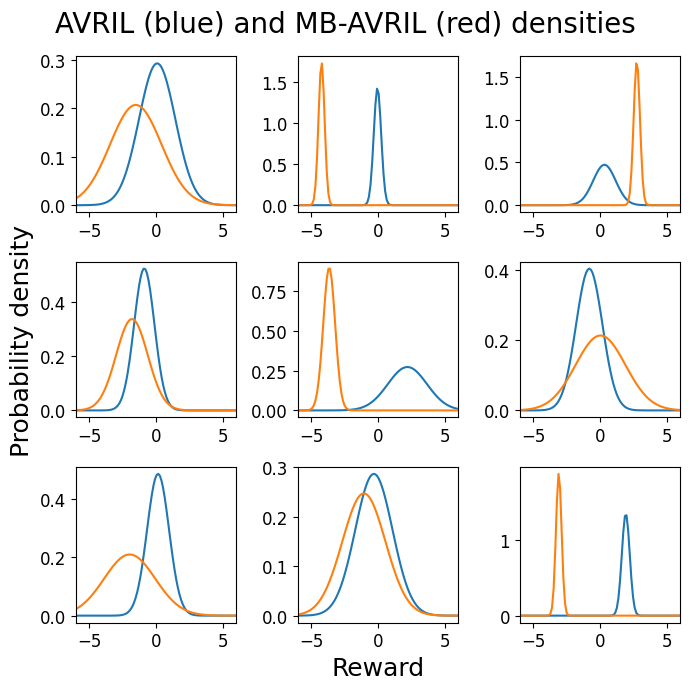

In [33]:
# Combine avril and mbavril in a single plot

x_lims = (-6, 6)

plt.figure(figsize=(7, 7))
avril_rew_model = avril_reward_model.reward_model
mbavril_rew_model = mbavril_reward_model.reward_model
r_plot = torch.linspace(*x_lims, 100)
for i in range(9):
    s = torch.nn.functional.one_hot(torch.tensor(i), num_classes=10, ).float()
    plt.subplot(3, 3, i + 1)
    m, log_var = avril_rew_model(s)
    dist = torch.distributions.Normal(m, log_var.exp().sqrt())
    plt.plot(r_plot, dist.log_prob(r_plot).exp().detach().numpy())
    
    m, log_var = mbavril_rew_model(s)
    dist = torch.distributions.Normal(m, log_var.exp().sqrt())
    plt.plot(r_plot, dist.log_prob(r_plot).exp().detach().numpy())

    
    plt.xlim(x_lims)
    # plt.ylim(0, 0.8)
    if i == 7:
        plt.xlabel('Reward', fontsize=18)
    if i == 3:
        plt.ylabel('Probability density', fontsize=18)
        
    # Set tick label font size for all subplots
    plt.tick_params(labelsize=12)
        

plt.suptitle("AVRIL (blue) and MB-AVRIL (red) densities", fontsize=20)
plt.tight_layout()

plt.savefig("avril_mbavril_reward_densities.pdf",bbox_inches='tight')


In [34]:
Q_sa = mbavril.q_network(torch.eye(10))

map shape: (9, 9), data type: float64


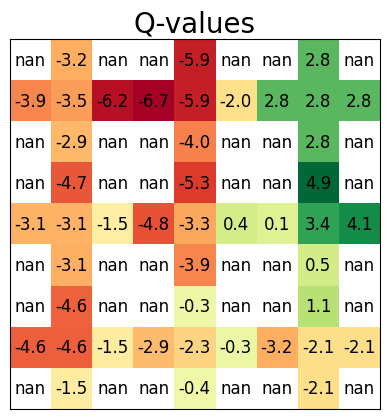

In [45]:
env.q_heatmap(Q_sa.detach().numpy(), cell_text_fontsize=12)

map shape: (9, 9), data type: float64


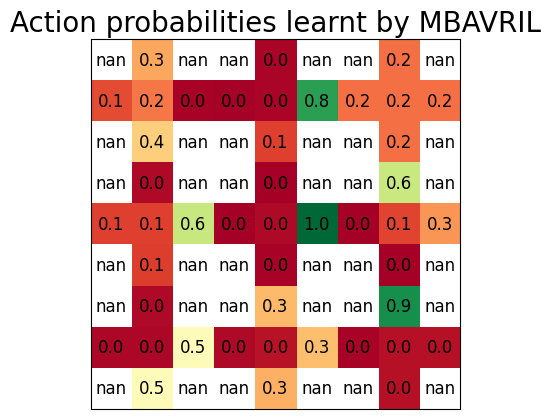

In [44]:
# Action probabilities
env.q_heatmap(torch.nn.functional.softmax(Q_sa, dim=1).detach().numpy(), title="Action probabilities learnt by MBAVRIL", cell_text_fontsize=12)

In [37]:
# List all MBAVRIL parameters
for name, param in mbavril.encoder.named_parameters():
    print(name, param)
    
for name, param in mbavril.q_network.named_parameters():
    print(name, param)

layers.weight Parameter containing:
tensor([[-0.9796, -3.6896,  3.2890, -1.2680, -3.1179,  0.5726, -1.4368, -0.5228,
         -2.5501,  0.5202],
        [ 1.6585, -2.6030, -2.5353,  0.6834, -1.2750,  1.5950,  1.6395,  1.3057,
         -2.7646, -2.6146]], requires_grad=True)
layers.bias Parameter containing:
tensor([-0.5204, -0.3472], requires_grad=True)
layers.weight Parameter containing:
tensor([[-3.2435, -5.7167,  2.9808, -2.8655, -3.0821,  3.6449, -4.3742, -2.0765,
         -1.8457,  0.2120],
        [-2.3475, -3.3607,  3.3650, -2.4921, -3.2566,  1.0467, -0.9244,  0.2071,
         -1.4615,  0.5962],
        [-5.7378, -1.5533,  3.2518, -0.9957,  0.8814,  4.5548, -1.0375,  0.1885,
         -1.5746,  0.4832],
        [-3.7157, -6.4754,  2.2225, -5.2621, -5.8076,  4.3969, -5.1181, -0.8647,
          0.5288, -0.5467],
        [-3.5775, -6.3862,  3.0463, -2.8000, -4.5323,  0.3887, -4.3087, -2.5751,
         -2.8898,  0.2775]], requires_grad=True)
layers.bias Parameter containing:
tensor([

map shape: (9, 9), data type: float64


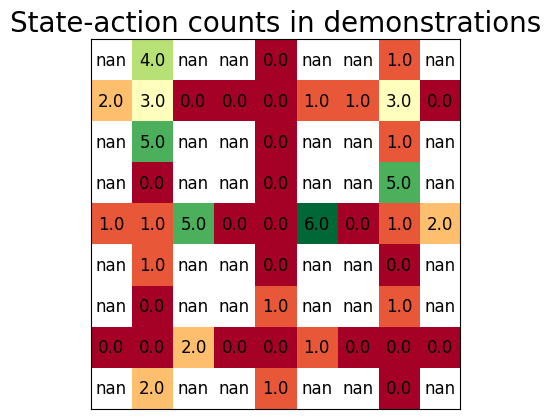

In [47]:
plot_demo_counts(D_onehot, env, cell_text_fontsize=12)

## 6. Generate and run experiments on larger gridworlds

In [ ]:
from experiments.birl.presets.gridworld_presets import get_6x6_irl_gridworld_config

seed = 1
beta_expert = 1.

# Set seeds in python, numpy and torch for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

env_config = get_6x6_irl_gridworld_config()
env_config.observation_type = ObservationType.index

demos_config = BoltzmannDemosConfig(
        demo_factory=collect_boltzmann_demos_factory_finite,
        total_samples=50,
        beta_expert=beta_expert,
        # demos_file_path=DATASET_DIR / "birl/gw_6x6_demos.pt,",
        append_last=False  # The env is now tweaked to yield an extra state at the end
    )
resolve_configurable_factories(env_config)
resolve_configurable_factories(demos_config)

env = env_config.env_factory()


In [ ]:
D = demos_config.demo_factory(env)


In [ ]:
irl_config = BayesianIRLConfig(
        irl_method_factory=PolicyWalk,
        beta_expert=1.,
        reward_prior_factory=get_independent_normal_prior,
        num_samples=1000,
        warmup_steps=100,
        num_params=env_config.num_states - 1,
        prior_scale=10.,
        reward_eval_points=env_config.width * env_config.height,
        hmc_adapt_mass_matrix=False,
        hmc_adapt_step_size=True,
        hmc_step_size=.1,
        hmc_num_steps=1000,
        hmc_use_nuts=True
)

resolve_configurable_factories(irl_config)
policy_walk = irl_config.irl_method_factory(env, irl_config)

In [ ]:
start_time = datetime.datetime.now()

policywalk_reward_model, info = policy_walk.run(D)

policywalk_runtime = datetime.datetime.now() - start_time
print(f"PolicyWalk runtime: {policywalk_runtime} s")


In [ ]:
from irl_algorithms.value_walk import value_walk_tabular

irl_config = BayesianIRLConfig(
    irl_method_factory=value_walk_tabular.ValueWalkTabular,
    beta_expert=1.,
    reward_prior_factory=get_independent_normal_prior,
    num_samples=1000,
    warmup_steps=100,
    num_params=env_config.num_states - 1,
    prior_scale=10.,
    reward_eval_points=env_config.width * env_config.height,
    hmc_adapt_mass_matrix=False,
    hmc_adapt_step_size=True,
    hmc_step_size=0.1,
    hmc_num_steps=1000,
    hmc_use_nuts=True
)
resolve_configurable_factories(irl_config)
value_walk = irl_config.irl_method_factory(env, irl_config)

In [ ]:
start_time = datetime.datetime.now()

value_walk_reward_model, info = value_walk.run(D)

value_walk_runtime = datetime.datetime.now() - start_time
print(f"ValueWalk runtime: {value_walk_runtime} s")

### 12x12 gridworld

In [ ]:
from experiments.birl.presets.gridworld_presets import get_12x12_irl_gridworld_config

env_config = get_12x12_irl_gridworld_config()
env_config.observation_type = ObservationType.index
resolve_configurable_factories(env_config)

env = env_config.env_factory()

D = demos_config.demo_factory(env)

In [ ]:
irl_config = BayesianIRLConfig(
        irl_method_factory=PolicyWalk,
        beta_expert=1.,
        reward_prior_factory=get_independent_normal_prior,
        num_samples=1000,
        warmup_steps=100,
        num_params=env_config.num_states - 1,
        prior_scale=10.,
        reward_eval_points=env_config.width * env_config.height,
        hmc_adapt_mass_matrix=False,
        hmc_adapt_step_size=True,
        hmc_step_size=.1,
        hmc_num_steps=1000,
        hmc_use_nuts=True
)

resolve_configurable_factories(irl_config)
policy_walk = irl_config.irl_method_factory(env, irl_config)

In [ ]:
start_time = datetime.datetime.now()

policywalk_reward_model, info = policy_walk.run(D)

policywalk_runtime = datetime.datetime.now() - start_time
print(f"PolicyWalk runtime: {policywalk_runtime} s")

In [ ]:
irl_config = BayesianIRLConfig(
    irl_method_factory=value_walk_tabular.ValueWalkTabular,
    beta_expert=1.,
    reward_prior_factory=get_independent_normal_prior,
    num_samples=1000,
    warmup_steps=100,
    num_params=env_config.num_states - 1,
    prior_scale=10.,
    reward_eval_points=env_config.width * env_config.height,
    hmc_adapt_mass_matrix=False,
    hmc_adapt_step_size=True,
    hmc_step_size=0.1,
    hmc_num_steps=1000,
    hmc_use_nuts=True
)
resolve_configurable_factories(irl_config)
value_walk = irl_config.irl_method_factory(env, irl_config)
start_time = datetime.datetime.now()

value_walk_reward_model, info = value_walk.run(D)

value_walk_runtime = datetime.datetime.now() - start_time
print(f"ValueWalk runtime: {value_walk_runtime} s")